In [169]:
import urllib
import zipfile
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from tqdm import tqdm
from pathlib import Path
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Input, Embedding, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import json

In [170]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(download_path: Path, url: str):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=download_path, reporthook=t.update_to)

def download_dataset(download_path: Path, url: str):
    print("Downloading dataset...")
    download_url(url=url, download_path=download_path)
    print("Download complete!")

def extract_dataset(zip_path: Path, extract_path: Path):
    print("Extracting all files from the ZIP archive... (it may take a while...)")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction completed!")

In [171]:
url = "http://205.174.165.80/CICDataset/NSL-KDD/Dataset/NSL-KDD.zip"
dataset_name = "NSL-KDD"

print(f"Current work directory: {Path.cwd()}")
dataset_folder = Path.cwd().joinpath("Datasets")

if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

dataset_zip_path = dataset_folder.joinpath("NSL-KDD.zip")
dataset_path = dataset_folder.joinpath(dataset_name)

if not dataset_zip_path.exists():
    download_dataset(dataset_zip_path, url)

if not dataset_path.exists():
    extract_dataset(dataset_zip_path, dataset_folder)

Current work directory: c:\Users\utente\Desktop\Università\Artificial Intelligence\Cybersecurity\Exam
Extracting all files from the ZIP archive... (it may take a while...)


Extraction completed!


In [172]:
df_train = pd.read_csv(str(dataset_folder)+'/KDDTrain+.txt',header=None)
df_test = pd.read_csv(str(dataset_folder)+'/KDDTest+.txt',header=None)
df_train = df_train.iloc[:, :-1]
df_test = df_test.iloc[:, :-1]
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [173]:
df_train[41] = df_train[41].replace(['normal'], 0)                                                                                  #NORMAL
df_test[41] = df_test[41].replace(['normal'], 0)
df_train[41] = df_train[41].replace(['ipsweep', 'nmap', 'portsweep', 'satan','perl'], 1)                                            #PROBE
df_test[41] = df_test[41].replace(['ipsweep', 'nmap', 'portsweep', 'satan'], 1)
df_train[41] = df_train[41].replace([ 'back', 'land', 'neptune', 'pod', 'smurf', 'teardrop'], 2)                                    #DoS
df_test[41] = df_test[41].replace([ 'back', 'land', 'neptune', 'pod', 'smurf', 'teardrop'], 2)
df_train[41] = df_train[41].replace(['buffer_overflow', 'loadmodule', 'rootkit'], 3)                                                #U2R
df_test[41] = df_test[41].replace(['buffer_overflow', 'loadmodule', 'rootkit'], 3)
df_train[41] = df_train[41].replace(['ftp_write', 'guess_passwd', 'imap', 'multihop','phf','spy', 'warezclient', 'warezmaster'], 4) #R2L
df_test[41] = df_test[41].replace(['ftp_write', 'guess_passwd', 'imap', 'multihop','phf','spy', 'warezclient', 'warezmaster'], 4)
df_train.head()
errors={0:'normal',1:'probe',2:'DoS',3:'U2R',4:'R2L'}

In [174]:
labelencoder_x_1 = LabelEncoder()
labelencoder_x_2 = LabelEncoder()
labelencoder_x_3 = LabelEncoder()
df_train[1] = labelencoder_x_1.fit_transform(df_train[1])
df_train[2] = labelencoder_x_2.fit_transform(df_train[2])
df_train[3] = labelencoder_x_3.fit_transform(df_train[3])
df_test[1] = labelencoder_x_1.fit_transform(df_test[1])
df_test[2] = labelencoder_x_2.fit_transform(df_test[2])
df_test[3] = labelencoder_x_3.fit_transform(df_test[3])
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,1,20,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,2,44,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,1,49,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,2
3,0,1,24,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,1,24,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


<AxesSubplot:>

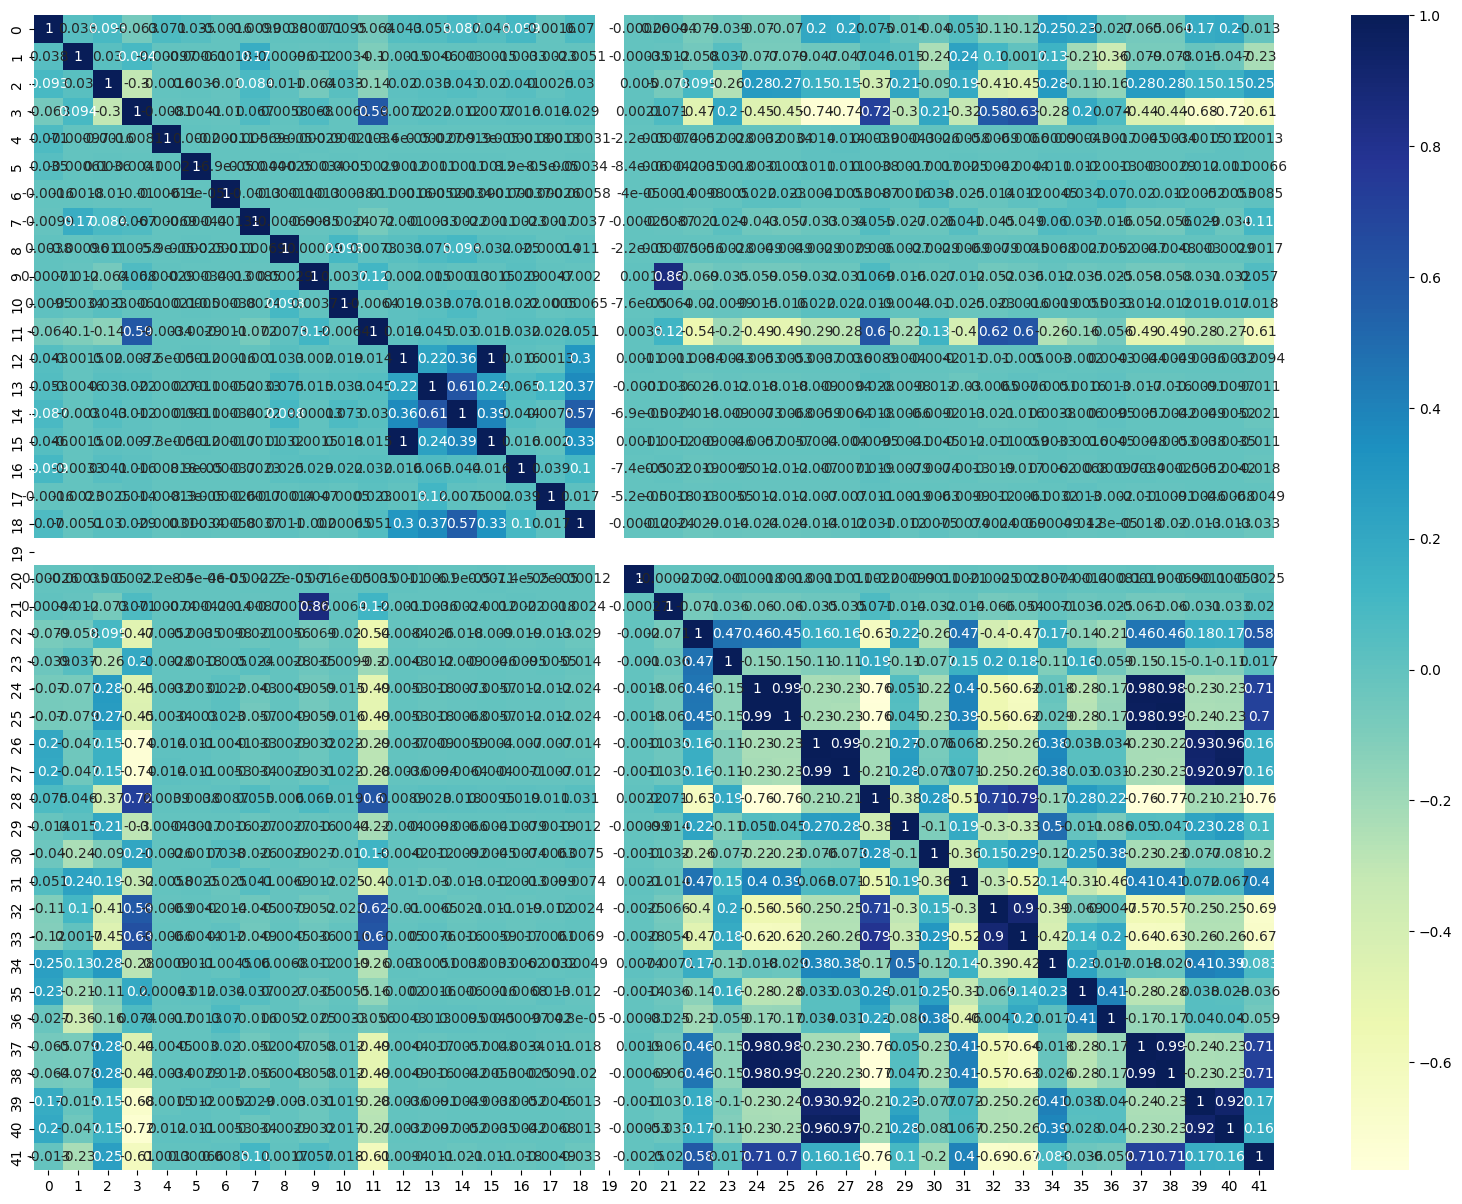

In [175]:
corr = df_train[df_train.columns].corr()                                             # CORRELATION MATRIX

plt.figure(figsize=(20, 15))
sns.heatmap(corr, cmap="YlGnBu", annot=True)

Since feature 12 and 15 has correlation 1 and feature 19 has always value 0, column 12 and 19 are deleted

In [176]:
df_train = df_train.drop(columns=[12, 19])
df_test = df_test.drop(columns=[12, 19])

In [177]:
x_train = df_train.iloc[:,:-1].values
y_train = df_train.iloc[:, -1].values
x_test = df_test.iloc[:,:-1].values
y_test = df_test.iloc[:, -1].values
print(x_train)
print(y_train)

[[0.0e+00 1.0e+00 2.0e+01 ... 0.0e+00 5.0e-02 0.0e+00]
 [0.0e+00 2.0e+00 4.4e+01 ... 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 1.0e+00 4.9e+01 ... 1.0e+00 0.0e+00 0.0e+00]
 ...
 [0.0e+00 1.0e+00 5.4e+01 ... 0.0e+00 1.0e-02 0.0e+00]
 [0.0e+00 1.0e+00 3.0e+01 ... 1.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 1.0e+00 2.0e+01 ... 0.0e+00 0.0e+00 0.0e+00]]
[0 0 2 ... 0 2 0]


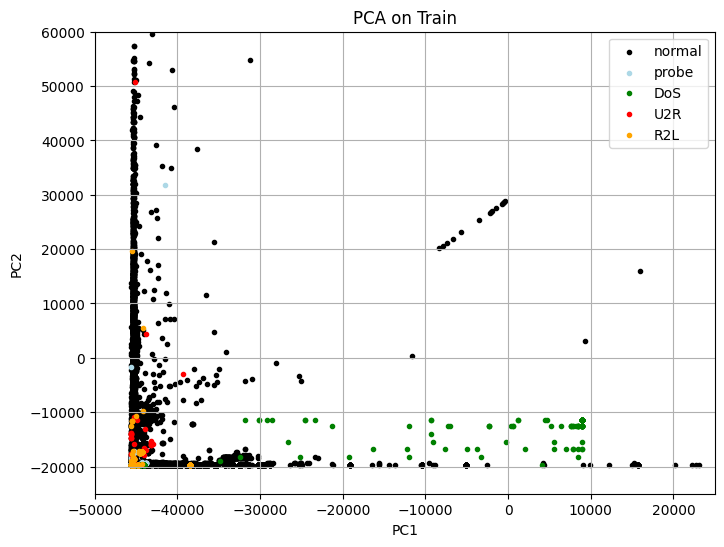

In [178]:
pca = PCA(n_components=3)

x_train_2d=pca.fit_transform(x_train)
#x_test_2d=pca.transform(x_test)

colori = ['black', 'lightblue', 'green', 'red', 'orange']
colori_classe = {classe: colore for classe, colore in zip([0,1,2,3,4], colori)}

plt.figure(figsize=(8, 6))

for classe in [0,1,2,3,4]:
    indici_train = (y_train == classe)
    #indici_test = (y_test == classe)
    plt.scatter(x_train_2d[indici_train, 0], x_train_2d[indici_train, 1], c=colori_classe[classe], marker='.', label=errors[classe])
    #plt.scatter(x_test_2d[indici_test, 0], x_test_2d[indici_test, 1], c=colori_classe[classe], marker='.')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA on Train')
plt.legend()
plt.grid(True)
plt.xlim(-50000, 25000)
plt.ylim(-25000, 60000)
plt.show()

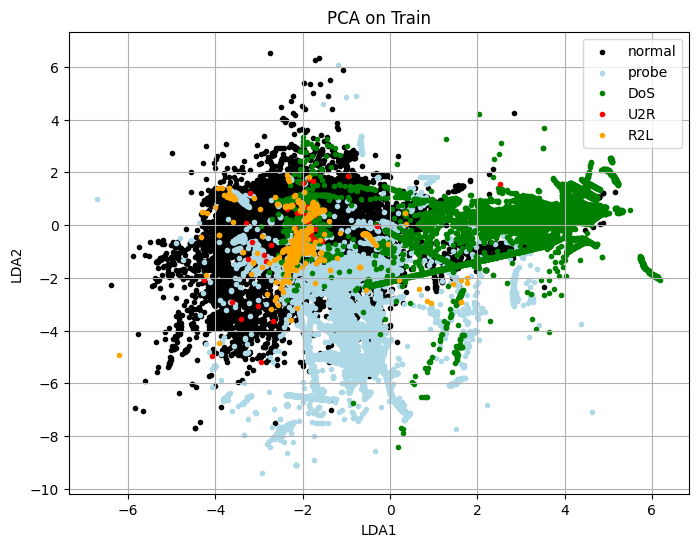

In [179]:
lda = LinearDiscriminantAnalysis(n_components=2)

x_train_2d=lda.fit_transform(x_train,y_train)
#x_test_2d=lda.transform(x_test)

colori = ['black', 'lightblue', 'green', 'red', 'orange']
colori_classe = {classe: colore for classe, colore in zip([0,1,2,3,4], colori)}

plt.figure(figsize=(8, 6))

for classe in [0,1,2,3,4]:
    indici_train = (y_train == classe)
    #indici_test = (y_test == classe)
    plt.scatter(x_train_2d[indici_train, 0], x_train_2d[indici_train, 1], c=colori_classe[classe], marker='.', label=errors[classe])
    #plt.scatter(x_test_2d[indici_test, 0], x_test_2d[indici_test, 1], c=colori_classe[classe], marker='.')

plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.title('PCA on Train')
plt.legend()
plt.grid(True)
plt.show()